In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from small_script.myFunctions import *
import feather
import Bio.PDB as bio

from sklearn.metrics import confusion_matrix


d3_to_index = bio.Polypeptide.d3_to_index  # we may want to adjust this in the future.
three_to_one = bio.Polypeptide.three_to_one
one_to_index = bio.Polypeptide.one_to_index

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.rcParams['figure.figsize'] = [16.18033, 10]

In [4]:

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.datasets import imdb
from keras.utils import to_categorical

from keras.models import model_from_json

from keras.metrics import top_k_categorical_accuracy

max_features = 20
batch_size = 1024*2
maxlen = 9
n = int(1e4)



Using TensorFlow backend.


# get test data into csv format

In [3]:
# get the real frag info
min_seq_sep=3
max_seq_sep=9
parser = bio.PDBParser(QUIET=True)
three_to_one = bio.Polypeptide.three_to_one

#         out.write("pdb,i,j,res1,res2,dis_ca_ca,dis_ca_cb,dis_cb_ca,dis_cb_cb\n")


def getFragInfoFromPdb(pdb_list, pre, testpre):
    for cc, p in enumerate(pdb_list):
        has_something = False
        name = p.lower()[:4]
        pdbId = pdb = name
        location = pre+f"{pdbId}/{pdbId}/crystal_structure.pdb"
        structure = parser.get_structure("x", location)
        with open(testpre+f"{pdbId}.csv", "w") as out:
            for model in structure:
                for chain in model:
                    all_residues = list(chain)
                    # print(all_residues)
                    for i, residue in enumerate(all_residues):
                        outLine = ""
                        need = True
                        dis_ca_ca = []
                        dis_ca_cb = []
                        dis_cb_ca = []
                        dis_cb_cb = []
                        resId = residue.get_id()[1]
                        frag = all_residues[i:i+max_seq_sep]
                        resseq_list = [x.get_id()[1] for x in frag]
                        fragSeq = "".join([three_to_one(x.get_resname()) for x in frag])
                        # print(i, fragSeq)
                        if len(frag) != 9:
                            continue
                        if not np.all(np.ediff1d(resseq_list)==1):
                        # print(f"mismatch, {resId}, {resseq_list}")
                            continue
                        for ii in range(7):
                            if not need:
                                break
                            try:
                                r1 = frag[ii]
                            except Exception as ex:
                                need = False
                                break
                            # print(i, residue.get_resname())
                            for j, r2 in enumerate(frag[(min_seq_sep+ii):]):
                                # The H of GLY is replaced with CB in this dataset
                                try:
                                    r2_cb = r2["CB"]
                                except Exception as ex:
                                    try:
                                        r2_cb = r2["CA"]
                                    except Exception as ex:
                                        # print(pdbId, resId)
                                        need = False
                                        break
                                try:
                                    r1_cb = r1["CB"]
                                except Exception as ex:
                                    try:
                                        r1_cb = r1["CA"]
                                    except Exception as ex:
                                        # print(pdbId, resId)
                                        need = False
                                        break
                                try:
                                    r1_ca = r1["CA"]
                                    r2_ca = r2["CA"]
                                except Exception as ex:
                                    print(pdbId, resId)
                                    # os.system(f"echo '{pdbId}' >> {pre}/without_discontinues_and_gly_exception_2")
                                    need = False
                                    break
                                dis_ca_ca.append(str(r1_ca-r2_ca))
                                dis_ca_cb.append(str(r1_ca-r2_cb))
                                dis_cb_ca.append(str(r1_cb-r2_ca))
                                dis_cb_cb.append(str(r1_cb-r2_cb))
                        if need:
                            outLine = f"{pdbId},{i},{fragSeq},"+",".join(dis_ca_ca)+\
                            ","+",".join(dis_ca_cb)+\
                            ","+",".join(dis_cb_ca)+\
                            ","+",".join(dis_cb_cb)+"\n"
                            out.write(outLine)



In [35]:
pre = "/Users/weilu/Research/server/jan_2019/iterative_optimization_another_set/all_simulations/"
testpre = "/Users/weilu/Research/optimization/fragment/testSet/"
pdb_list = "1FC2C, 1ENH, 2GB1, 2CRO, 1CTF, 4ICB".split(", ")
getFragInfoFromPdb(pdb_list, pre, testpre)


headline = "pdb,i,seq," + ",".join([f"caca_{i}" for i in range(1,22)]) + \
        "," + ",".join([f"cacb_{i}" for i in range(1,22)]) + \
        "," + ",".join([f"cbca_{i}" for i in range(1,22)]) + \
        "," + ",".join([f"cbcb_{i}" for i in range(1,22)]) 

# combine all to one data.
folder = "testSet"
combined_csv = "test_data"
os.system(f"echo '{headline}' > /Users/weilu/Research/optimization/fragment/{combined_csv}.csv")
pdb_list = os.listdir(f"/Users/weilu/Research/optimization/fragment/{folder}/")
for cc, pdb in enumerate(pdb_list):
    os.system(f"cat /Users/weilu/Research/optimization/fragment/{folder}/{pdb} >> /Users/weilu/Research/optimization/fragment/{combined_csv}.csv")



# pipline from test data to accuracy

In [5]:
data_original = pd.read_csv("/Users/weilu/Research/optimization/fragment/test_data.csv")

In [6]:
import pickle
# pickle.dump(kmeans, open("kmeans_cluster100_v2", "wb"))
kmeans = pickle.load(open("/Users/weilu/Research/optimization/fragment/kmeans_cluster100_v2_2", "rb"))

In [7]:
data_original["cluster"] = kmeans.predict(data_original.iloc[:, 3:87].values)
def getScore(data, km):
    return np.sqrt(((km.cluster_centers_[int(data.values[-1])] - data.values[:-1])**2).sum())
data_original["rmsd"] = data_original.iloc[:,3:88].apply(lambda x: getScore(x, kmeans), axis=1)

In [8]:
data = data_original[["pdb", "i", "seq","cluster", "rmsd"]].reset_index(drop=True)
data["cluster"] = data["cluster"].astype(int)
for i in range(1,10):
    data[f"s{i}"] = data["seq"].apply(lambda x: one_to_index(x[i-1]))

In [14]:
# pre = "/Users/weilu/Research/server/jan_2019/lstm100_v3/"
pre = "/Users/weilu/Research/server/feb_2019/lstm100_2/"
json_file = open(f"{pre}/model.json", "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights(f"{pre}/model.h5")

In [15]:
x_test = data.iloc[:, 5:14].values
y_test_value = data["cluster"].values
y_test = to_categorical(np.array(y_test_value), num_classes=100)

In [16]:
def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)
def top_10_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=10)
def top_20_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=20)
loaded_model.compile('adam', 'categorical_crossentropy', metrics=['accuracy', top_3_accuracy, 
                                                                  top_5_accuracy, 
                                                                  top_10_accuracy, top_20_accuracy])

In [17]:
top_n = 20
all_frag = []
for fragSeq in data_original["seq"]:
    fragIndex = [one_to_index(x) for x in fragSeq]
    all_frag.append(fragIndex)
all_frag = np.array(all_frag)
predict_prob = loaded_model.predict(all_frag)
clusters = np.argsort(-predict_prob)[:, :top_n]
for i in range(top_n):
    data_original[f"pred_top{i+1}"] = clusters[:,i]

In [18]:
loaded_model.evaluate(x_test, y_test)

315/315 [==============================] - 0s 1ms/step


[2.9926906101287356,
 0.3238095232891658,
 0.5238095233364711,
 0.6285714295175341,
 0.7904761910438538,
 0.8952380939135476]

In [33]:
loaded_model.evaluate(x_test, y_test)

315/315 [==============================] - 0s 1ms/step


[2.9926906101287356,
 0.3238095232891658,
 0.5238095233364711,
 0.6285714295175341,
 0.7904761910438538,
 0.8952380939135476]

In [15]:
loaded_model.evaluate(x_test, y_test)

315/315 [==============================] - 0s 162us/step


[2.9494901664673336,
 0.24761904769000553,
 0.4571428561021411,
 0.5904761914222959,
 0.7333333344686599,
 0.8666666691265409]

In [119]:
loaded_model.evaluate(x_test, y_test)

315/315 [==============================] - 0s 928us/step


[3.0338871017334954,
 0.2730158725428203,
 0.46984127012510146,
 0.561904764175415,
 0.6793650791758583,
 0.8253968278566997]

In [85]:
def getRMSD(data, km, cluder_index_column):
    return np.sqrt(((km.cluster_centers_[int(data.values[cluder_index_column])] - data.values[:84])**2).sum())
for i in range(top_n):
    data_original[f"pred_top{i+1}_dRMSD"] = data_original.iloc[:,3:].apply(lambda x: getRMSD(x, kmeans, 86+i), axis=1)

In [87]:
data = data_original.iloc[:, 87:]

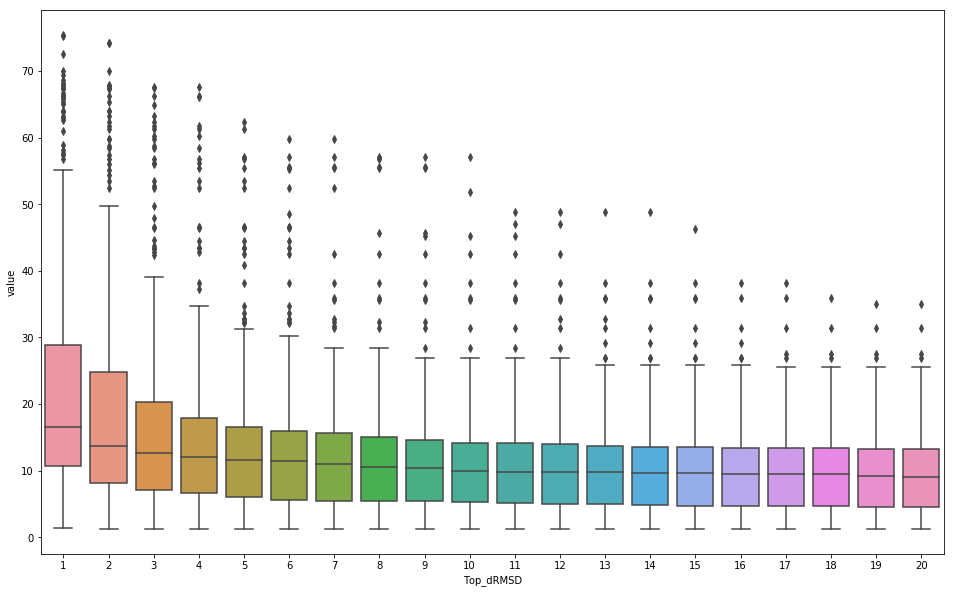

In [132]:
p1 = data.iloc[:,22:]
def minRMSD(data, n):
    return np.min(data.values[:n])
for i in range(top_n):
    p1[f"averageTop{i+1}"] = p1.apply(lambda x: minRMSD(x, i+1), axis=1)
p1 = p1.iloc[:,20:].reset_index().melt(id_vars=["index"], var_name="dRMSD")
p1["Top_dRMSD"] = processed_data["dRMSD"].str.split("_").apply(lambda x: int(x[1][3:]))
sns.boxplot("Top_dRMSD", "value", data=p1)

# average

In [127]:
p1 = data.iloc[:,22:]
def averageRMSD(data, n):
    return np.average(data.values[:n])
for i in range(top_n):
    p1[f"averageTop{i+1}"] = p1.apply(lambda x: averageRMSD(x, i+1), axis=1)
p1 = p1.iloc[:,20:].reset_index().melt(id_vars=["index"], var_name="dRMSD")
p1["Top_dRMSD"] = processed_data["dRMSD"].str.split("_").apply(lambda x: int(x[1][3:]))

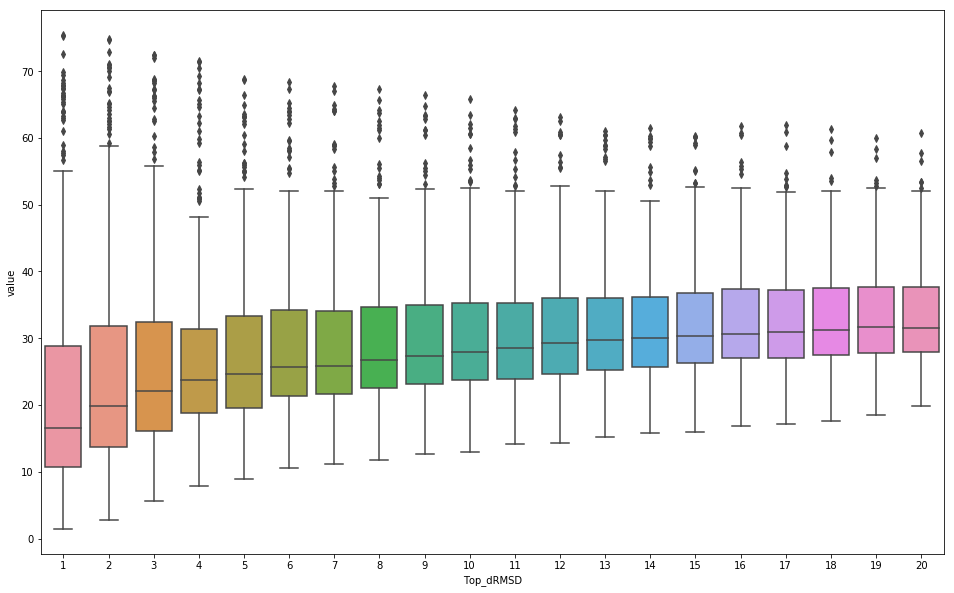

In [130]:
sns.boxplot("Top_dRMSD", "value", data=p1)

# i th

In [100]:
processed_data = data.iloc[:,22:].reset_index().melt(id_vars=["index"], var_name="dRMSD")
processed_data["Top_dRMSD"] = processed_data["dRMSD"].str.split("_").apply(lambda x: int(x[1][3:]))

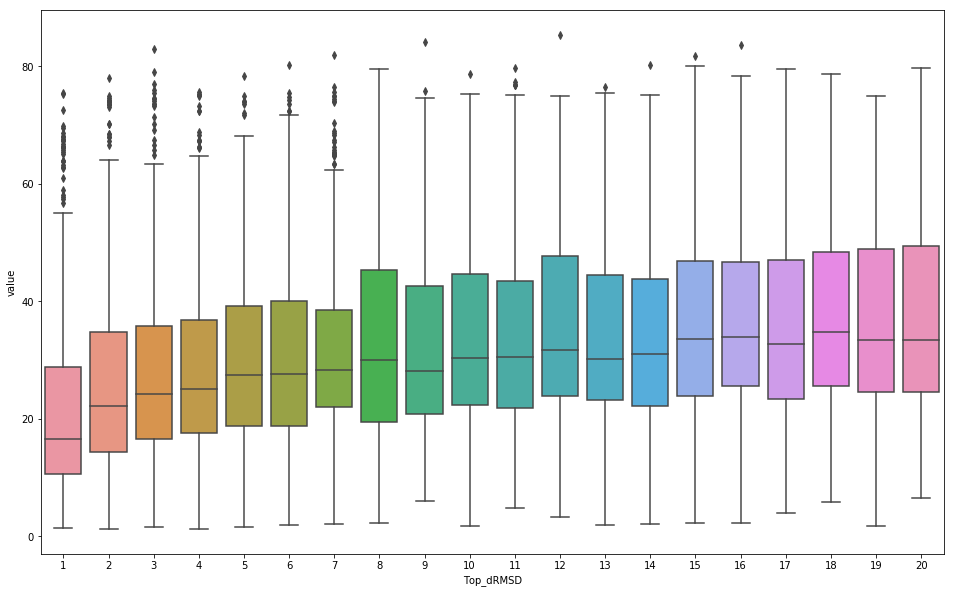

In [111]:
sns.boxplot("Top_dRMSD", "value", data=processed_data)

In [93]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
cluster,315.0,47.311111,26.460493,0.000000,28.500000,55.000000,56.000000,98.000000
rmsd,315.0,8.754763,4.702357,1.202327,4.425866,8.587541,12.565353,19.827993
pred_top1,315.0,46.342857,30.840403,0.000000,19.000000,48.000000,72.500000,99.000000
pred_top2,315.0,45.688889,31.018359,0.000000,16.000000,48.000000,71.000000,99.000000
pred_top3,315.0,45.888889,29.775653,0.000000,19.000000,48.000000,70.000000,99.000000
pred_top4,315.0,48.787302,29.261219,0.000000,23.000000,52.000000,71.000000,99.000000
pred_top5,315.0,45.206349,30.882641,0.000000,17.500000,44.000000,71.000000,99.000000
pred_top6,315.0,49.130159,28.683517,0.000000,23.000000,53.000000,71.000000,99.000000
pred_top7,315.0,49.755556,30.528163,0.000000,20.500000,52.000000,75.000000,99.000000
pred_top8,315.0,43.968254,28.942051,0.000000,19.000000,45.000000,67.000000,99.000000


In [19]:
def getFrags(pdb, toLocation, top_n=1, evenWeight=True):
    seqFile = f"/Users/weilu/Research/server/jan_2019/iterative_optimization_another_set/all_simulations/{pdb}/{pdb}/{pdb}.seq"
    with open(seqFile) as f:
        lines = f.readlines()
    a = lines[0].strip()
    all_frag = []
    for i in range(0, len(a)-8):
        frag = a[i:i+9]
        # print(frag)
        fragIndex = [one_to_index(x) for x in frag]
        # print(fragIndex)
        all_frag.append(fragIndex)
    all_frag = np.array(all_frag)
    predict_prob = loaded_model.predict(all_frag)
    clusters = np.argsort(-predict_prob)[:, :top_n]
    n = predict_prob.shape[0]
    prob = predict_prob[np.arange(n).reshape(n,1), clusters]
    prob /= (prob.sum(axis=1)).reshape(n,1)
    # pre = "/Users/weilu/Research/server/jan_2019/iterative_optimization_another_set/fragment_memory/"
    pre = toLocation
    header = '''\
[Target]
query

[Memories]
'''
    with open(pre+f"{pdb}.mem", "w") as out:
        out.write(header)
        if evenWeight:
            weight = 20/top_n
        for index, c in enumerate(clusters):
            for index2, i in enumerate(c):
                if not evenWeight:
                    weight = prob[index][index2]
                out.write(f"fraglib/{i}.gro {index+1} 1 9 {weight:.3}\n")

In [23]:
pdb_list = "1FC2C, 1ENH, 2GB1, 2CRO, 1CTF, 4ICB".split(", ")
pre = "/Users/weilu/Research/server/feb_2019/iterative_optimization_new_temp_range/"
for p in pdb_list:
    name = p.lower()[:4]
    getFrags(name, pre, top_n=20, evenWeight=True)

In [ ]:
pdb = "1ctf"
top_n = 2
seqFile = f"/Users/weilu/Research/server/jan_2019/iterative_optimization_another_set/all_simulations/{pdb}/{pdb}/{pdb}.seq"
with open(seqFile) as f:
    lines = f.readlines()
a = lines[0].strip()
all_frag = []
for i in range(0, len(a)-8):
    frag = a[i:i+9]
    # print(frag)
    fragIndex = [one_to_index(x) for x in frag]
    # print(fragIndex)
    all_frag.append(fragIndex)
all_frag = np.array(all_frag)
predict_prob = loaded_model.predict(all_frag)
clusters = np.argsort(-predict_prob)[:, :top_n]
# cluster100_centers.to_feather("/Users/weilu/Research/optimization/fragment/cluster_centers.feather")
cluster100_centers = feather.read_dataframe("/Users/weilu/Research/optimization/fragment/cluster_centers.feather")

In [77]:
fragSeq = "NEEQRNGFI"
predict_prob = loaded_model.predict(np.array([one_to_index(x) for x in fragSeq]).reshape(1,9))
np.argsort(-predict_prob)[:, :10]

array([[16, 86, 48, 23, 55,  1, 62, 58, 12, 99]])

In [67]:
top_n = 2
all_frag = []
for fragSeq in data_original["seq"]:
    fragIndex = [one_to_index(x) for x in fragSeq]
    all_frag.append(fragIndex)
all_frag = np.array(all_frag)
predict_prob = loaded_model.predict(all_frag)
clusters = np.argsort(-predict_prob)[:, :top_n]

In [73]:
data_original = data_original.assign(pred_top1=clusters[:,0], pred_top2=clusters[:,1])

In [78]:
from keras.metrics import top_k_categorical_accuracy

In [85]:
data.head()

,pdb,i,seq,cluster,rmsd,s1,s2,s3,s4,s5,s6,s7,s8,s9
0,1bg6A02,107,RAVNVPTPL,0,5.756177,14,0,17,11,17,12,16,12,9
1,3g85A02,38,HKNGIKISE,0,6.329374,6,8,11,5,7,8,7,15,3
2,4je5C00,166,EAQGVITFP,0,6.365145,3,0,13,5,17,7,16,4,12
3,3q41A01,88,GFYRIPVLG,0,6.389094,5,4,19,14,7,12,17,9,5
4,1auqA00,144,KKKKVIVIP,0,6.450880,8,8,8,8,17,7,17,7,12


In [65]:

np.argsort(-predict_prob)[:, :top_n]

array([[19, 12]])

In [ ]:
pdb = "1ctf"

seqFile = f"/Users/weilu/Research/server/jan_2019/iterative_optimization_another_set/all_simulations/{pdb}/{pdb}/{pdb}.seq"
with open(seqFile) as f:
    lines = f.readlines()
a = lines[0].strip()
all_frag = []
for i in range(0, len(a)-8):
    frag = a[i:i+9]
    # print(frag)
    fragIndex = [one_to_index(x) for x in frag]
    # print(fragIndex)
    all_frag.append(fragIndex)
all_frag = np.array(all_frag)
predict_prob = loaded_model.predict(all_frag)
clusters = np.argsort(-predict_prob)[:, :top_n]